In [1]:
import random
import math
import os
from argparse import ArgumentParser, Namespace
from collections import Counter
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Any, Dict, List, Optional, Set, Tuple, Union, Callable
from typing_extensions import Literal

import ipywidgets as widgets
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.isomorphism as iso
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from easydict import EasyDict as edict
from ipywidgets import interact
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from torch import FloatTensor, LongTensor, Tensor
from torch_geometric.data import Batch, Data, InMemoryDataset
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GINConv, GNNExplainer, global_max_pool
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.models import GIN
from torch_geometric.utils import k_hop_subgraph, remove_self_loops, to_networkx
from tqdm.notebook import trange, tqdm

## configs

In [2]:
@dataclass
class Args:
    """A class containing arguments used for setting up the dataset and model."""
    batch_size: int = 32  # Batch size for the training loop.
    num_workers: int = 2  # Number of workers to use for the data loader.
    learning_rate: float = 0.001  # Learning rate.
    weight_decay: float = 5e-4  # Weight decay.
    num_epochs: int = 300  # Number of training epochs.
    num_layers: int = 3  # Number of message passing layers in the GNN model.
    hidden_features: int = 32  # Dimensionality of the hidden layers in the GNN.
    dropout: float = 0.2  # Dropout probability.
    seed: int = 27  # Random seed.
    pre_train: bool = True  # Change to False if want to retrain

args = Args()

In [3]:
rng = np.random.default_rng(args.seed)
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

# Dataset Loading

In [4]:
# Load MUTAG dataset (graph classification)
mutag_dataset = edict()
mutag_dataset.ds = TUDataset(
    'data/mutag/',
    name='MUTAG',
    use_node_attr=True,
    use_edge_attr=True
)
mutag_dataset.ds.shuffle()
mutag_size = len(mutag_dataset.ds)
mutag_dataset.train_ds = mutag_dataset.ds[:int(0.8 * mutag_size)]
mutag_dataset.valid_ds = mutag_dataset.ds[int(0.8 * mutag_size) : int(0.9 * mutag_size)]
mutag_dataset.test_ds = mutag_dataset.ds[int(0.9 * mutag_size):]

# Since MUTAG has multiple graphs, we use DataLoaders to load the graphs
mutag_train_loader = DataLoader(
    dataset=mutag_dataset.train_ds,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    shuffle=True
)
mutag_valid_loader = DataLoader(
    dataset=mutag_dataset.valid_ds,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    shuffle=False
    )
mutag_test_loader = DataLoader(
    dataset=mutag_dataset.test_ds,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    shuffle=False
)

# Simple GNN Model

In [5]:
class GIN_SubgraphX(torch.nn.Module):
    """The GIN model from the SubgraphX paper.

    Adapted from https://github.com/divelab/DIG/blob/dig/dig/xgraph/models/models.py
    """
    def __init__(self, 
                in_channels: int, 
                hidden_channels: int, 
                num_layers: int, 
                out_channels: int, 
                dropout: float = 0.5):
        super(GIN_SubgraphX, self).__init__()

        self.dropout = dropout

        convs_list = [
            GINConv(nn.Sequential(
                nn.Linear(in_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU())
            )
        ]
        convs_list += [
            GINConv(nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU())
            )
            for _ in range(num_layers - 1)
        ]

        self.convs = nn.ModuleList(convs_list)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels), 
            nn.ReLU(), 
            nn.Dropout(self.dropout), 
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, 
                x: LongTensor, 
                edge_index: LongTensor, 
                batch: LongTensor) -> FloatTensor:
        for i in range(len(self.convs)):
            x = self.convs[i](x, edge_index)

        x = global_max_pool(x, batch)

        x = self.classifier(x)

        return x

In [6]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
# Load MUTAG GIN model and optimizer
mutag_model = GIN_SubgraphX(
    in_channels=mutag_dataset.ds.num_features,
    hidden_channels=args.hidden_features,
    num_layers=args.num_layers,
    out_channels=1,
    dropout=args.dropout
).to(device)

print('MUTAG model')
print(mutag_model)

mutag_optimizer = torch.optim.Adam(
    mutag_model.parameters(),
    lr=args.learning_rate, 
    weight_decay=args.weight_decay
)

MUTAG model
GIN_SubgraphX(
  (convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=7, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    ))
    (1): GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    ))
    (2): GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    ))
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)


## training

In [8]:
class AverageMeter(object):
    """The AverageMeter keeps track of an average value over multiple updates."""
    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        """Resets the meter."""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        """Updates the meter with a value and a count.

        :param val: The value to add to the running sum.
        :param n: The count, i.e., the number of items included in val.
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
def run_epoch_graph_cls(loader: DataLoader,
                        model: nn.Module,
                        optimizer: torch.optim.Adam,
                        device: torch.device,
                        mode: Literal['train', 'valid', 'test'] = False) -> None:
    """Runs an epoch (train or eval) of a graph classification model/dataset."""
    epoch_loss = AverageMeter()
    epoch_acc = AverageMeter()

    if mode == 'train':
        model.train()
    else:
        model.eval()

    preds, targets = [], []

    for batch in loader:
        batch = batch.to(device)

        if mode == 'train':
            optimizer.zero_grad()

        out = model(batch.x.float(), batch.edge_index, batch.batch)

        pred = out.squeeze()
        target = batch.y.float().squeeze()

        preds.append(pred.detach().cpu().numpy())
        targets.append(target.detach().cpu().numpy())

        loss = F.binary_cross_entropy_with_logits(
            input=pred,
            target=target
        )

        if mode == 'train':
            loss.backward()
            optimizer.step()

        epoch_loss.update(loss.detach().item(), out.shape[0])
        
        batch_acc = ((torch.sigmoid(out) > 0.5).int().flatten() == batch.y).float().mean()
        epoch_acc.update(batch_acc, out.shape[0])

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    epoch_auc = roc_auc_score(y_true=targets, y_score=preds)

    print(f'{mode} loss in the epoch: {epoch_loss.avg:.3f}, '
          f'{mode} accuracy in the epoch: {epoch_acc.avg:.3f}, '
          f'{mode} auc in the epoch: {epoch_auc:.3f}')

## classificatioon model here!

In [10]:
if args.pre_train != True or not os.path.exists('pre_train/mutag.pth'):
    # Train MUTAG model
    for epoch in range(args.num_epochs):
        print(f'Epoch {epoch}')

        # Train loop
        run_epoch_graph_cls(
            loader=mutag_train_loader,
            model=mutag_model,
            optimizer=mutag_optimizer,
            device=device,
            mode='train'
        )

        # Validation loop
        run_epoch_graph_cls(
            loader=mutag_valid_loader,
            model=mutag_model,
            optimizer=mutag_optimizer,
            device=device,
            mode='valid'
        )

    # save model
    torch.save(mutag_model, 'pre_train/mutag.pth')
else:
    # load pre trained model
    mutag_model = torch.load('pre_train/mutag.pth', map_location=device)
    mutag_model.eval()    

# Test loop
run_epoch_graph_cls(
    loader=mutag_test_loader,
    model=mutag_model,
    optimizer=mutag_optimizer,
    device=device,
    mode='test'
)

test loss in the epoch: 0.456, test accuracy in the epoch: 0.737, test auc in the epoch: 0.845


# Explaination

## GNNExplaniner

In [11]:
# Create GNNExplainer model for MUTAG
mutag_explainer = GNNExplainer(mutag_model, epochs=2000, return_type='raw', log=False)

## visualization functions

In [12]:
def visualize_subgraph_mutag(graph: nx.Graph,
                             node_set: Optional[Set[int]] = None,
                             edge_set: Optional[Set[int]] = None,
                             title: Optional[str] = None) -> None:
    """Visualizes a subgraph explanation for a graph from the MUTAG dataset.

    Note: Only provide subgraph_node_set or subgraph_edge_set, not both.

    Adapted from https://github.com/divelab/DIG/blob/dig/dig/xgraph/method/subgraphx.py

    :param graph: A NetworkX graph object representing the full graph.
    :param node_set: A set of nodes that induces a subgraph.
    :param edge_set: A set of edges that induces a subgraph.
    :param title: Optional title for the plot.
    """
    if node_set is None:
        node_set = set(graph.nodes())

    if edge_set is None:
        edge_set = {(n_from, n_to) for (n_from, n_to) in graph.edges() if n_from in node_set and n_to in node_set}

    # node_dict = {0: 'C', 1: 'N', 2: 'O', 3: 'F', 4: 'I', 5: 'Cl', 6: 'Br'}
    node_idxs = {node: node_x.index(1.0) for node, node_x in graph.nodes(data='x')}
    # node_labels = {k: node_dict[v] for k, v in node_idxs.items()}
    node_color = ['#E49D1C', '#4970C6', '#FF5357', '#29A329', 'brown', 'darkslategray', '#F0EA00']
    colors = [node_color[v % len(node_color)] for k, v in node_idxs.items()]

    pos = nx.kamada_kawai_layout(graph)

    nx.draw_networkx_nodes(G=graph, pos=pos, nodelist=list(graph.nodes()), node_color=colors, node_size=300)
    nx.draw_networkx_edges(G=graph, pos=pos, width=3, edge_color='gray', arrows=False)
    nx.draw_networkx_edges(G=graph, pos=pos, edgelist=list(edge_set), width=6, edge_color='black', arrows=False)
    # nx.draw_networkx_labels(G=graph, pos=pos, labels=node_labels)
    nx.draw_networkx_labels(G=graph, pos=pos)

    if title is not None:
        plt.title(title)

    plt.axis('off')
    plt.show()
    plt.close()

In [13]:
def visualize_explanation_for_graph(threshold: float, graph_idx: int) -> None:
    """Visualizes the explanations of GNNExplainer for a graph given a mask threshold."""
    mutag_data = mutag_dataset.test_ds[graph_idx]

    _, edge_mask = mutag_explainer.explain_graph(mutag_data.x.to(device), mutag_data.edge_index.to(device))

    batch = torch.zeros(mutag_data.x.shape[0], dtype=int, device=device)
    output = mutag_model(mutag_data.x.to(device), mutag_data.edge_index.to(device), batch)
    pred = torch.sigmoid(output).item()

    edge_set = {(edge[0].item(), edge[1].item()) for edge, mask in zip(mutag_data.edge_index.T, edge_mask) if mask > threshold}
    graph = to_networkx(mutag_data, node_attrs=['x'], edge_attrs=['edge_attr'], to_undirected=True)

    visualize_subgraph_mutag(
        graph=graph,
        edge_set=edge_set,
        title=f'GNNExplainer on graph {graph_idx}: label = {mutag_data.y.item()}, pred = {pred:.2f}'
    )

## Interactive GNNExplainer

In [14]:
# Interactive exploration of GNNExplainer explanations on MUTAG
@interact(threshold=widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01), 
            graph_idx=widgets.IntSlider(value=0, min=0, max=18))
def interactive_mutag_explanations(threshold: float, graph_idx: int) -> None:
    visualize_explanation_for_graph(threshold, graph_idx)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), IntSlider(value=0, …

## Genetic algorithm

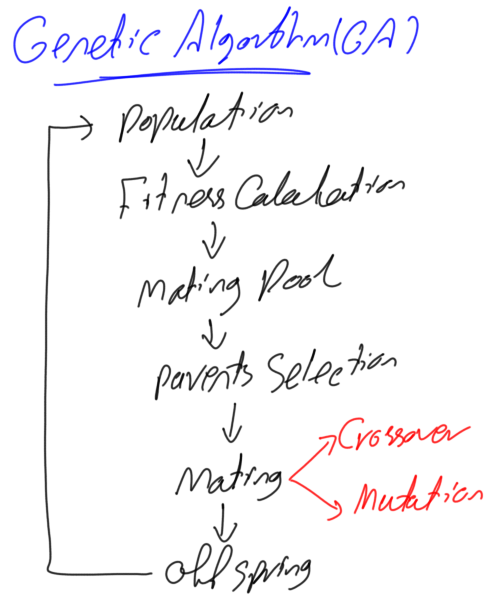

In [15]:
from deap import base
from deap import creator
from deap import tools


In [16]:
from torch_geometric.utils import k_hop_subgraph, get_num_hops

## creator

### extract L-hop of arbitary network

In [17]:
foo_sample = mutag_dataset.test_ds[0]

In [18]:
model_hops = get_num_hops(mutag_model)

In [19]:
# example
# sub_nodes, edge_index, _, edge_mask = k_hop_subgraph(1, model_hops, foo_sample.edge_index, )

In [20]:
def subgraph(node_idx, x, edge_index, num_hops):
        subset, edge_index, _, edge_mask = k_hop_subgraph(node_idx, num_hops, edge_index)
        x = x[subset]
        return x, edge_index, subset, edge_mask

In [21]:
# example
# a,b,c,d = subgraph(1, foo_sample.x, foo_sample.edge_index, model_hops)

### extract subgraph from a vertex

In [22]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", tuple, fitness=creator.FitnessMax)

In [23]:
toolbox = base.Toolbox()

In [24]:
def generator(subgraph_fn: partial, node_sampling: partial):
    _ , subset_edges, subset_nodes , _ =  subgraph_fn(node_sampling())
    return subset_nodes, subset_edges

In [38]:
def graph_build_zero_filling(X, edge_index, node_mask: torch.Tensor):
    """ subgraph building through masking the unselected nodes with zero features """
    ret_X = X * node_mask.unsqueeze(1)
    return ret_X, edge_index

def graph_build_split(X, edge_index, node_mask: torch.Tensor):
    """ subgraph building through spliting the selected nodes from the original graph """
    row, col = edge_index
    edge_mask = (node_mask[row] == 1) & (node_mask[col] == 1)
    ret_edge_index = edge_index[:, edge_mask]
    return X, ret_edge_index

def get_graph_build_func(build_method):
    if build_method.lower() == 'zero_filling':
        return graph_build_zero_filling
    elif build_method.lower() == 'split':
        return graph_build_split
    else:
        raise NotImplementedError

def gnn_score(coalition: list, data: Data, value_func: Callable,
              subgraph_building_method='zero_filling') -> torch.Tensor:
    """ the value of subgraph with selected nodes """
    num_nodes = data.num_nodes
    subgraph_build_func = get_graph_build_func(subgraph_building_method)
    mask = torch.zeros(num_nodes).type(torch.float32).to(data.x.device)
    mask[coalition] = 1.0
    ret_x, ret_edge_index = subgraph_build_func(data.x, data.edge_index, mask)
    mask_data = Data(x=ret_x, edge_index=ret_edge_index)
    mask_data = Batch.from_data_list([mask_data])
    score = value_func(mask_data)
    # get the score of predicted class for graph or specific node idx
    return score.item()

def get_fitness_func(score_method, gnn_model, subgraph_building_method='zero_filling'):
    """ Function factory to generate a method measure how quality of a individual
    Args:
        score_method: method to use
        gnn_model:  a blackbox algorithm
        subgraph_building_method: way to construct a suggraph
    """
    if score_method.lower() == 'gnn_score':
        return partial(gnn_score,
                       value_func=gnn_model,
                       subgraph_building_method=subgraph_building_method)
    else:
        raise NotImplementedError

def wrap_value_func(data):
    out = mutag_model(x=data.x.to(device), edge_index=data.edge_index.to(device), batch=None)
    prod = torch.sigmoid(out)
    return prod

def evalSubGraph(individual, origin_graph):
    nodes = individual[0][0].detach().tolist()
    # edges = individual[0][1]
    fitness_func = get_fitness_func('gnn_score', wrap_value_func)
    fitness_value = fitness_func(coalition=nodes, data=origin_graph)
    return fitness_value + (1 - len(nodes)/origin_graph.num_nodes), fitness_value


In [26]:
# toolbox.register("attr_bool", random.randint, 0, 1)
# toolbox.register("individual", tools.initRepeat, creator.Individual, 
#     toolbox.attr_bool, 100)
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# def evalOneMax(individual):
#     return sum(individual),

# toolbox.register("evaluate", evalOneMax)
# toolbox.register("mate", tools.cxTwoPoint)
# toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
# toolbox.register("select", tools.selTournament, tournsize=3)

In [27]:
toolbox.register("random_node", random.randrange, 0, foo_sample.num_nodes)
toolbox.register("subgraph", subgraph, x=foo_sample.x , edge_index=foo_sample.edge_index, num_hops=model_hops)
toolbox.register("generator",  generator, toolbox.subgraph, toolbox.random_node)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.generator, 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [28]:
pop = toolbox.population(n=3)

In [29]:
bar = toolbox.individual()

In [39]:
hop = evalSubGraph(bar, foo_sample)

In [ ]:
batch = torch.zeros(foo_sample.x.shape[0], dtype=int, device=device)
output = mutag_model(foo_sample.x.to(device), foo_sample.edge_index.to(device), batch)
torch.sigmoid(output).item()

In [42]:
# batch = torch.zeros(foo_sample.x.shape[0], dtype=int, device=device)
output = mutag_model(foo_sample.x.to(device), foo_sample.edge_index.to(device), **{'batch': None})
torch.sigmoid(output).item()

0.3681658208370209

In [40]:
hop

(0.5910948392222909, 0.2969771921634674)